In [1]:
# baseline model with weight decay on the cifar10 dataset
import sys
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
# from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import PIL
from PIL import Image as im
import cv2

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print("FIM")
print(tf.__version__)

FIM
2.3.0


# Convertendo imagens do dataset de ".tif" para ".png"

In [ ]:
# import os, glob

# input_dir = "/media/user1-lipai/Data/image_datasets/histopathologics/Oral cancer/displasia - camundongos/OralEpitheliumDB/Original ROI images/severe"
# output_dir = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/OralEpitheliumDB/Original ROI images/severe"

# os.makedirs(output_dir, exist_ok=True)

# for filepath in glob.glob(os.path.join(input_dir, "*.tif")):
#     img = im.open(filepath)
#     base = os.path.basename(filepath)
#     name = os.path.splitext(base)[0]
#     img.save(os.path.join(output_dir, name + ".png"))
# print("FIM")

# Separando dataset em treino, validação e teste

In [9]:
# import splitfolders

# data_dir = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/OralEpitheliumDB/Original ROI images"
# splitfolders.ratio(data_dir,seed=1337, output="Splitted Original ROI images", ratio=(0.69, 0.21, 0.1))
# print("FIM")

Copying files: 456 files [00:00, 3080.03 files/s]

FIM


In [2]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Compatibilidade com diferentes versões do TensorFlow
AUTOTUNE = getattr(tf.data, "AUTOTUNE", tf.data.experimental.AUTOTUNE)

train_dir = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/train"
val_dir = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/val"

# Parâmetros
img_size = (224, 224)
batch_size = 32
val_split = 0.3

# Cria dataset de treino
train_ds_base = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Cria dataset de validação
val_ds_base = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Normaliza as imagens no formato da ResNet50
# (isso aplica o mesmo pré-processamento usado no treinamento original da ResNet)
train_ds = train_ds_base.map(lambda x, y: (preprocess_input(x), y)).shuffle(5)
val_ds = val_ds_base.map(lambda x, y: (preprocess_input(x), y))

# Opcional: melhora performance no carregamento
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 312 files belonging to 4 classes.
Found 92 files belonging to 4 classes.


In [89]:
test_dir = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/test"
test_ds_base = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Normaliza as imagens no formato da ResNet50
# (isso aplica o mesmo pré-processamento usado no treinamento original da ResNet)
test_ds = val_ds_base.map(lambda x, y: (preprocess_input(x), y))

# Opcional: melhora performance no carregamento
test_ds = val_ds.prefetch(AUTOTUNE)

Found 52 files belonging to 4 classes.


In [29]:
class_names = train_ds_base.class_names
print(class_names)

['healthy', 'mild', 'moderate', 'severe']


In [30]:
# Modelo ResNet50

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("FIM")

FIM


In [31]:
# fit model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
10/10 [==============================] - 2s 164ms/step - loss: 1.6757 - accuracy: 0.3846 - val_loss: 1.0246 - val_accuracy: 0.5761
Epoch 2/100
10/10 [==============================] - 1s 114ms/step - loss: 1.1047 - accuracy: 0.5288 - val_loss: 0.8441 - val_accuracy: 0.6304
Epoch 3/100
10/10 [==============================] - 1s 118ms/step - loss: 0.8350 - accuracy: 0.6795 - val_loss: 0.7782 - val_accuracy: 0.7283
Epoch 4/100
10/10 [==============================] - 1s 119ms/step - loss: 0.6957 - accuracy: 0.7212 - val_loss: 0.7044 - val_accuracy: 0.6739
Epoch 5/100
10/10 [==============================] - 1s 117ms/step - loss: 0.5978 - accuracy: 0.7788 - val_loss: 0.6494 - val_accuracy: 0.7391
Epoch 6/100
10/10 [==============================] - 1s 118ms/step - loss: 0.5291 - accuracy: 0.7853 - val_loss: 0.6104 - val_accuracy: 0.7609
Epoch 7/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4361 - accuracy: 0.8365 - val_loss: 0.5645 - val_accuracy: 0.8152

Epoch 58/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0277 - accuracy: 0.9936 - val_loss: 0.4819 - val_accuracy: 0.8043
Epoch 59/100
10/10 [==============================] - 1s 118ms/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.4024 - val_accuracy: 0.8261
Epoch 60/100
10/10 [==============================] - 1s 118ms/step - loss: 0.0306 - accuracy: 0.9936 - val_loss: 0.4029 - val_accuracy: 0.8261
Epoch 61/100
10/10 [==============================] - 1s 119ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.4286 - val_accuracy: 0.8261
Epoch 62/100
10/10 [==============================] - 1s 116ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.4422 - val_accuracy: 0.8261
Epoch 63/100
10/10 [==============================] - 1s 117ms/step - loss: 0.0201 - accuracy: 0.9968 - val_loss: 0.4304 - val_accuracy: 0.8261
Epoch 64/100
10/10 [==============================] - 1s 120ms/step - loss: 0.0156 - accuracy: 0.9968 - val_loss: 0.4148 - val_accuracy:

In [90]:
# evaluate model
_, acc = model.evaluate(test_ds)
print('> %.3f' % (acc * 100.0))

3/3 [==============================] - 0s 36ms/step - loss: 0.4498 - accuracy: 0.8370
> 83.696


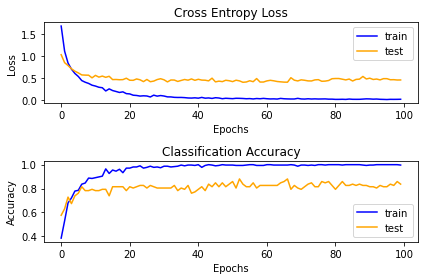

In [82]:
# plot diagnostic learning curves

# plot loss
plt.subplot(2,1,1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot accuracy
plt.subplot(2,1,2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# save plot to file
plt.tight_layout()
figs_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/ResNet50/oral_epithelium/figures/"
plt.savefig(figs_path + 'OralEpithelium_ResNet50' + '_train_plot.png', dpi=300, bbox_inches='tight')

# plot fig
plt.show()
plt.close()

In [4]:
model.save('/home/user1-lipai/Maycon/TCC_Maycon_XAI/ResNet50/oral_epithelium/models/resnet50_oral_epithelium')
print("FIM")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/user1-lipai/Maycon/TCC/ResNet50/models/resnet50_histological/assets
FIM


In [3]:
model = tf.keras.models.load_model('/home/user1-lipai/Maycon/TCC_Maycon_XAI/ResNet50/oral_epithelium/models/resnet50_oral_epithelium')
print("FIM")

FIM


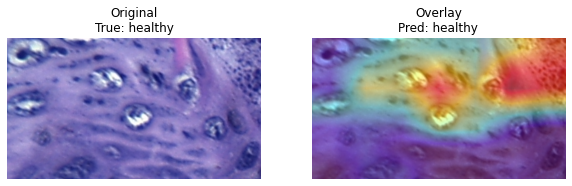

In [58]:
from tensorflow.keras.preprocessing import image

# ============================================
# Função para carregar imagem
# ============================================
def load_image(img_path, target_size=(224, 224)):
    orig_img = image.load_img(img_path)
    img_resized = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return orig_img, img_array

# ============================================
# Função para gerar Grad-CAM
# ============================================

# Função Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.layers[0]
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    conv_model = tf.keras.Model(base_model.input, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = tf.keras.layers.GlobalAveragePooling2D()(classifier_input)
    for layer in model.layers[2:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array)
        tape.watch(conv_outputs)
        preds = classifier_model(conv_outputs)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
#         print(f"Gradientes None para classe {pred_index}")
        return np.zeros(conv_outputs.shape[1:3])

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) == 0:
        return np.zeros_like(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

    # Gradientes
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Grad-CAM
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ============================================
# Função para sobrepor Grad-CAM na imagem original
# ============================================
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img = np.array(img)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img.astype('uint8'))
    plt.title(f"Original\nTrue: {orig_label}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img[..., ::-1].astype('uint8'))
    plt.title(f"Overlay\nPred: {classes[pred_class]}")
    plt.axis('off')
    plt.show()
    
    #Salva a imagem
    cv2.imwrite("figures/gradcam_histological_output.png", superimposed_img)

# ============================================
# Exemplo de uso
# ============================================
# img_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/val/severe/image013-roi3.png"
# img_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/val/severe/image034-roi5.png"
img_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/val/healthy/image067-roi2.png"
# img_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/val/moderate/image037-roi2.png"
# img_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/databases/Splitted Original ROI images/val/mild/image021-roi5.png"
parts = img_path.split("/")
orig_label = parts[-2]
orig_img, preprocessed_img = load_image(img_path)

preds = model.predict(preprocessed_img)
pred_class = np.argmax(preds[0])
classes = ["healthy", "mild", "moderate", "severe"]

# Nome da última camada convolucional da ResNet50
last_conv_layer_name = "conv5_block3_out"

# Gera o mapa Grad-CAM
heatmap = make_gradcam_heatmap(preprocessed_img, model, last_conv_layer_name)

# Exibe o resultado
display_gradcam(orig_img, heatmap)

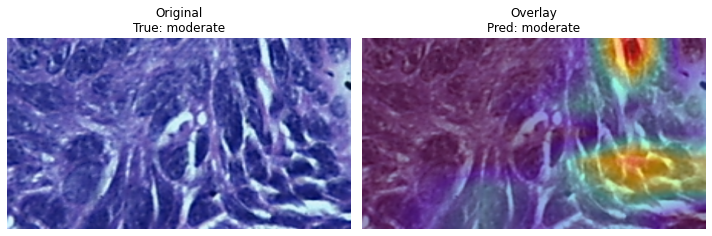

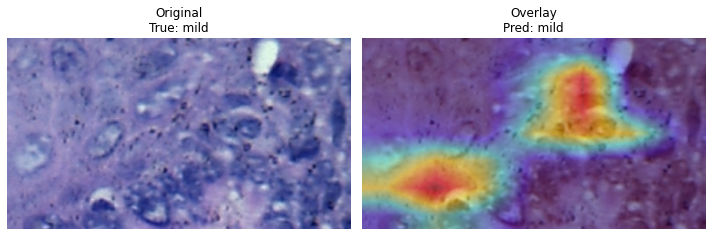

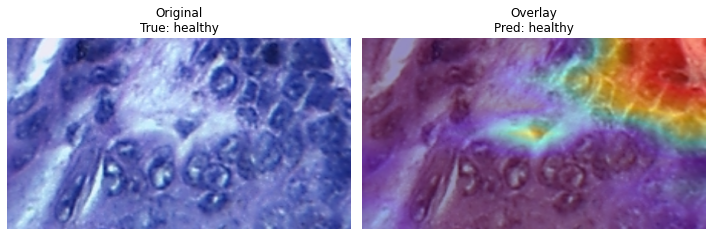

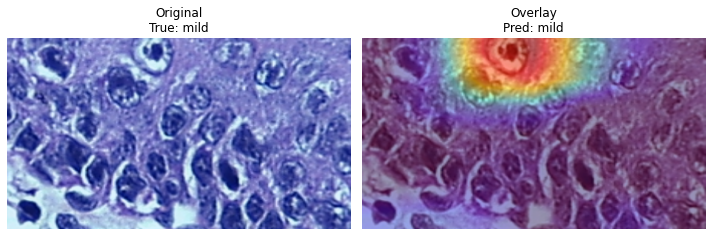

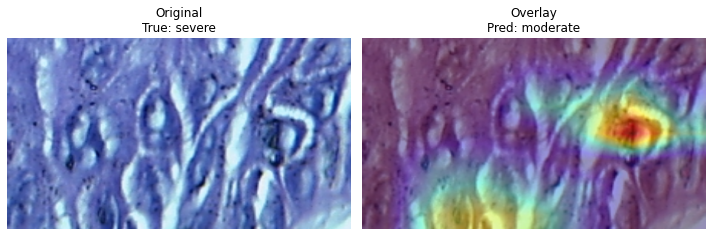

In [61]:
from tensorflow.keras.preprocessing import image

# ============================================
# Função para gerar Grad-CAM
# ============================================

# Função Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.layers[0]
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    conv_model = tf.keras.Model(base_model.input, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = tf.keras.layers.GlobalAveragePooling2D()(classifier_input)
    for layer in model.layers[2:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array)
        tape.watch(conv_outputs)
        preds = classifier_model(conv_outputs)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
#         print(f"Gradientes None para classe {pred_index}")
        return np.zeros(conv_outputs.shape[1:3])

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) == 0:
        return np.zeros_like(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

    # Gradientes
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Grad-CAM
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ============================================
# Função para sobrepor Grad-CAM na imagem original
# ============================================
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img = np.array(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img.astype('uint8'))
    plt.title(f"Original\nTrue: {orig_label_str}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img[..., ::-1].astype('uint8'))
    plt.title(f"Overlay\nPred: {classes[pred_class]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    #Salva a imagem
    cv2.imwrite("figures/gradcam_histological_output.png", superimposed_img)

# ============================================
# Exemplo de uso
# ============================================

classes = ["healthy", "mild", "moderate", "severe"]
last_conv_layer_name = "conv5_block3_out"
count = 0
for batch_images, batch_labels in val_ds.take(1):
    for i in range(batch_images.shape[0]):
        if count >= 5:
            break

        img_tensor = batch_images[i]
        orig_label_int = batch_labels[i].numpy()
        orig_label_str = classes[orig_label_int]

        # pré-processar tensor
        img_array = tf.expand_dims(img_tensor, axis=0)  # adiciona dimensão de batch

        # Predição
        preds = model.predict(img_array)
        pred_class = np.argmax(preds[0])

        # Grad-CAM
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Converte tensor para PIL Image
        img_tensor = tf.image.resize(img_tensor, (250, 450))
        orig_img = tf.keras.preprocessing.image.array_to_img(img_tensor)

        # Exibe
        display_gradcam(orig_img, heatmap)

        count += 1